# Replicating the Results of Dey *et al.* 2014
This notebook describes the creation of machine learning models for the band gaps for chalcopyrite compounds, following the paper by [Dey *et al.* (2014)](http://dx.doi.org/10.1016/j.commatsci.2013.10.016). In particular, recreates the hyper-parameter tuning, model evaluation, and feature selection reported in this work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, LeaveOneOut

%matplotlib inline

## Load Training Data

The data for this notebook was extracted from Tables 1 and 2 from the original paper. These are stored as `csv` files in the same directory as this notebook, for convenience.

### Load element data file into a Pandas Dataframe
`element_data.csv` contains elemental properties for the all possible elements in the search space, which was provided in Table 1 of the paper.

Specifically, this file contains:
- EN: Electronegativity
- AN: Atomic Number
- MP: Melting point (K)
- PR: Pseudopotential radius (as defined by [Suh and Rajan (2004)](http://www.sciencedirect.com/science/article/pii/S0169433203009188?via%3Dihub))
- VL: Valency (as defined by as given by [Suh and Rajan (2004)](http://www.sciencedirect.com/science/article/pii/S0169433203009188?via%3Dihub))

In [2]:
#Load input data into dictionary
elem_data = pd.read_csv("datasets/dey_element_data.csv")
elem_properties = elem_data.set_index("#ELM").T.to_dict("list")
print elem_properties

{'As': [2.27, 33.0, 1089.0, 1.415, 5.0], 'Zn': [1.44, 30.0, 692.7, 1.88, 12.0], 'Ge': [1.99, 32.0, 1211.0, 1.56, 4.0], 'Ag': [1.07, 47.0, 1235.0, 2.375, 11.0], 'S': [2.65, 16.0, 388.4, 1.1, 6.0], 'Al': [1.64, 13.0, 933.5, 1.675, 3.0], 'Cd': [1.4, 48.0, 594.3, 2.215, 12.0], 'P': [2.32, 15.0, 317.3, 1.24, 5.0], 'Si': [1.98, 14.0, 1687.0, 1.42, 4.0], 'Se': [2.54, 34.0, 494.0, 1.285, 6.0], 'Sn': [1.88, 50.0, 505.1, 1.88, 4.0], 'Ga': [1.7, 31.0, 302.9, 1.695, 3.0], 'In': [1.63, 49.0, 429.8, 2.05, 3.0], 'Te': [2.38, 52.0, 722.7, 1.67, 6.0], 'Cu': [1.08, 29.0, 1358.0, 2.04, 11.0]}


### Load training data
`training_set.csv` contains experimentally determined band gap values for each compound.

In [7]:
training_file = "datasets/dey_training_set.csv"
training_set = pd.read_csv("datasets/dey_training_set.csv")
training_set.columns=["composition","band_gaps"]
training_set

,composition,band_gaps
0,CuAlS2,3.49
1,CuAlSe2,2.67
2,CuAlTe2,2.06
3,CuGaS2,2.43
4,CuGaSe2,1.68
5,CuGaTe2,1.12
6,CuInS2,1.53
7,CuInSe2,1.04
8,CuInTe2,1.06
9,AgAlS2,3.13


Generate the features

## Compute Attributes
Attributes are what serve as input in to the machine learning model. In this section, we compute attributes given the composition of the materials.

All of the compounds in the training set are $ABC_2$ compounds where $A$ are Cu-group elements, Zn-group elements, Be, or Mg; $B$ are Group III or IV elements, and $C$ are Group VI or V elements.

Following Dey *et al.*, we compute features based on the elemental properties of the $A$, $B$, and $C$ elements using all available elemental properties

In [13]:
attributes = np.zeros((len(training_set), 15))

elem_re = re.compile('[A-Z][a-z]?')

# LW 7Jul17: Can we make this into a DataFrame as well, 
#            so that it captures feature names and stores
#            them for later use. This way, we don't re-generate
#            them later (e.g., during the attribute selection)
for i in range(len(training_set)):
    elements = elem_re.findall(training_set["composition"][i])
    for j in range(len(elements)):
        attributes[i,5*j:5*(j+1)] = elem_properties[elements[j]]

attr_labels = ["EN", "AN", "MP", "PR", "VL"]
atom_labels = ["A", "B", "C"]

labels = []
for i in range(len(atom_labels)):
    for j in range(len(attr_labels)):
        labels.append("%s_%s"%(attr_labels[j], atom_labels[i]))

training_set = training_set.assign(
    **dict(zip(labels, [attributes[:, i] for i in range(np.shape(attributes)[1])])))

training_set

,composition,band_gaps,AN_A,AN_B,AN_C,EN_A,EN_B,EN_C,MP_A,MP_B,MP_C,PR_A,PR_B,PR_C,VL_A,VL_B,VL_C
0,CuAlS2,3.49,29.0,13.0,16.0,1.08,1.64,2.65,1358.0,933.5,388.4,2.040,1.675,1.100,11.0,3.0,6.0
1,CuAlSe2,2.67,29.0,13.0,34.0,1.08,1.64,2.54,1358.0,933.5,494.0,2.040,1.675,1.285,11.0,3.0,6.0
2,CuAlTe2,2.06,29.0,13.0,52.0,1.08,1.64,2.38,1358.0,933.5,722.7,2.040,1.675,1.670,11.0,3.0,6.0
3,CuGaS2,2.43,29.0,31.0,16.0,1.08,1.70,2.65,1358.0,302.9,388.4,2.040,1.695,1.100,11.0,3.0,6.0
4,CuGaSe2,1.68,29.0,31.0,34.0,1.08,1.70,2.54,1358.0,302.9,494.0,2.040,1.695,1.285,11.0,3.0,6.0
5,CuGaTe2,1.12,29.0,31.0,52.0,1.08,1.70,2.38,1358.0,302.9,722.7,2.040,1.695,1.670,11.0,3.0,6.0
6,CuInS2,1.53,29.0,49.0,16.0,1.08,1.63,2.65,1358.0,429.8,388.4,2.040,2.050,1.100,11.0,3.0,6.0
7,CuInSe2,1.04,29.0,49.0,34.0,1.08,1.63,2.54,1358.0,429.8,494.0,2.040,2.050,1.285,11.0,3.0,6.0
8,CuInTe2,1.06,29.0,49.0,52.0,1.08,1.63,2.38,1358.0,429.8,722.7,2.040,2.050,1.670,11.0,3.0,6.0
9,AgAlS2,3.13,47.0,13.0,16.0,1.07,1.64,2.65,1235.0,933.5,388.4,2.375,1.675,1.100,11.0,3.0,6.0


## Test Regression Methods
In this section, we evaluate the performance of different machine learning models. As the original code used by Dey *et al* is not available, we attempt to implement these methods using [scikit-learn](http://scikit-learn.org/stable/) where possible.

_LW 7Jul17_: I think we include hyper-parameter tuning in this section. Right now, it is not apparent where the parameter choices come from. And, I'm surprised that LASSO does worse than OLS, which makes me skeptical about these parameters being optimal

We first determine the optimal hyper-parameters for each model. We then compare their fitness on the original training set and in cross-validation.

_LW 7Jul17_: I'm writing these section headers to make this notebook read like a paper. Having the notebooks be "self-describing" in this way would make them much more valuable additions to WholeTale, as they can be read knowing little about the original work.

First, we define a general fitting function. It runs a fitting procedure using the provided regression method implemented in sci-kit learn.

In [6]:
def fit_data(attributes, band_gaps, test_set=attributes, method=None, **kwargs):
    """ General function to fit a regression model and make a prediction
        Args:    attributes (ndarray or DataFrame) 
                 band_gaps (ndarray)
        Returns: updated DataFrame (ndarray)
    """

    # LW 7Jul17: We should define what each argument means
    model = method(**kwargs)
    model.fit(attributes, band_gaps)
    if np.size(np.shape(test_set)) == 1:
        test_set = test_set.reshape(1,-1)
    prediction = model.predict(test_set)
    return prediction

1) Ordinary Linear Regression

In [7]:
# LW 7Jul17: Following up on earlier comment, could we store this data as
#             another column in a dataframe, rather than a separate variable?

# LW 7Jul17: I moved the import statements to the top, following convention
ols_predict = fit_data(attributes, band_gaps, method=LinearRegression, fit_intercept=False)
data = pd.DataFrame(list(zip(compounds, ols_predict)), columns=["composition", "band gaps"])
print data

   composition  band gaps
0       CuAlS2   3.235556
1      CuAlSe2   2.550556
2      CuAlTe2   2.183889
3       CuGaS2   2.372222
4      CuGaSe2   1.687222
5      CuGaTe2   1.320556
6       CuInS2   1.822222
7      CuInSe2   1.137222
8      CuInTe2   0.770556
9       AgAlS2   3.312222
10     AgAlSe2   2.627222
11     AgAlTe2   2.260556
12      AgGaS2   2.448889
13     AgGaSe2   1.763889
14     AgGaTe2   1.397222
15      AgInS2   1.898889
16     AgInSe2   1.213889
17     AgInTe2   0.847222
18      ZnSiP2   2.434500
19     ZnSiAs2   1.620500
20      ZnGeP2   1.884500
21     ZnGeAs2   1.070500
22      CdSiP2   2.224500
23     CdSiAs2   1.410500
24      CdGeP2   1.674500
25     CdGeAs2   0.860500
26      CdSnP2   1.122000
27     CdSnAs2   0.308000


2) Lasso, implemented with LARS

In [8]:
lasso_predict = fit_data(attributes, band_gaps, method=LassoLars, alpha=0.01, fit_intercept=False, max_iter=13)
data = pd.DataFrame(list(zip(compounds, lasso_predict)), columns=["composition", "band gaps"])
print data

   composition  band gaps
0       CuAlS2   3.135487
1      CuAlSe2   2.629939
2      CuAlTe2   2.074376
3       CuGaS2   2.414128
4      CuGaSe2   1.908580
5      CuGaTe2   1.353016
6       CuInS2   1.830268
7      CuInSe2   1.324721
8      CuInTe2   0.769157
9       AgAlS2   3.133693
10     AgAlSe2   2.628146
11     AgAlTe2   2.072582
12      AgGaS2   2.412334
13     AgGaSe2   1.906787
14     AgGaTe2   1.351223
15      AgInS2   1.828475
16     AgInSe2   1.322928
17     AgInTe2   0.767364
18      ZnSiP2   2.386208
19     ZnSiAs2   1.610020
20      ZnGeP2   1.692911
21     ZnGeAs2   0.916723
22      CdSiP2   2.423418
23     CdSiAs2   1.647230
24      CdGeP2   1.730121
25     CdGeAs2   0.953933
26      CdSnP2   0.995094
27     CdSnAs2   0.218905


3) Partial Least Squares Regression

In [9]:
pls_predict = fit_data(attributes, band_gaps, method=PLSRegression, n_components=8, scale=False)
data = pd.DataFrame(list(zip(compounds, pls_predict)), columns=["composition", "band gaps"])
print data

   composition         band gaps
0       CuAlS2   [3.24978654118]
1      CuAlSe2   [2.53840310909]
2      CuAlTe2   [2.20233750874]
3       CuGaS2   [2.44346133122]
4      CuGaSe2   [1.73207789913]
5      CuGaTe2   [1.39601229878]
6       CuInS2   [1.87863151208]
7      CuInSe2   [1.16724807999]
8      CuInTe2  [0.831182479645]
9       AgAlS2   [3.24509933662]
10     AgAlSe2   [2.53371590453]
11     AgAlTe2   [2.19765030418]
12      AgGaS2   [2.43877412666]
13     AgGaSe2   [1.72739069457]
14     AgGaTe2   [1.39132509422]
15      AgInS2   [1.87394430752]
16     AgInSe2   [1.16256087543]
17     AgInTe2  [0.826495275079]
18      ZnSiP2   [2.42937011588]
19     ZnSiAs2   [1.60833005687]
20      ZnGeP2   [1.71747086241]
21     ZnGeAs2  [0.896430803399]
22      CdSiP2   [2.38922607937]
23     CdSiAs2   [1.56818602035]
24      CdGeP2    [1.6773268259]
25     CdGeAs2  [0.856286766886]
26      CdSnP2   [1.15115792464]
27     CdSnAs2  [0.330117865621]


3) Sparse Partial Least Squares

_LW 7Jul17_: I did some digging on SPLS. The only implementation of this method I found is in R ([docs](https://cran.r-project.org/web/packages/spls/spls.pdf)), which would be a pain to use (though possible) from Python. We should, perhaps, mention that it is not implemented in Python and, given that it has the worst performance in Dey *et al*, we elect to not test it here.

### Plot predicted vs measured results

This generates a plot of band gaps predicted using each regression method vs. band gaps determined experimentally.


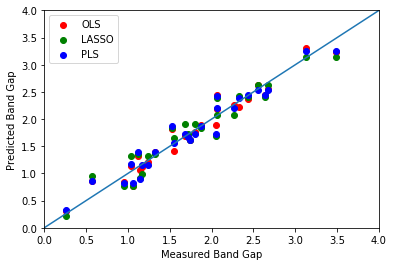

In [10]:
#band_gaps_predicted = np.zeros(np.shape(band_gaps))

plt.scatter(band_gaps, ols_predict, color='r', label="OLS")
plt.scatter(band_gaps, lasso_predict, color='g', label="LASSO")
plt.scatter(band_gaps, pls_predict, color='b', label="PLS")

plt.legend()
plt.xlabel("Measured Band Gap")
plt.ylabel("Predicted Band Gap")
plt.axis([0,4,0,4])
plt.plot(np.array(range(0,5)), np.array(range(0,5)))

## Calculate Mean Square Cross-Validation Error

Crossvalidate all the regression methods using Leave-One-Out method

In [11]:
##Crossvalidation


def cross_validate(attributes, band_gaps, method=LinearRegression, **kwargs):
    # LW 7Jul17: cross_val_score is parallelized. Given how long the later cells take, perhaps we should use n_jobs=None here
    errors = cross_val_score(method(**kwargs), attributes, band_gaps, scoring='neg_mean_squared_error', cv=LeaveOneOut())
    mscve = np.mean(np.abs(errors))
    return mscve

ols_mscve = cross_validate(attributes, band_gaps, LinearRegression, fit_intercept=False)
lasso_mscve = cross_validate(attributes, band_gaps, LassoLars, alpha=0.01, fit_intercept=False, max_iter=13)
pls_mscve = cross_validate(attributes, band_gaps, PLSRegression, n_components=8, scale=False)

print "Mean-Squared Cross-Validation Errors \n"
print "OLS: %f"%ols_mscve
print "LASSO: %f"%lasso_mscve
print "PLS: %f"%pls_mscve

Mean-Squared Cross-Validation Errors 

OLS: 0.072714
LASSO: 0.073337
PLS: 0.065627


_LW 7Jul17_: Insert some discussion about how well this agrees / does not agree with the findings of Dey *et al*

## Feature Subset Selection
Here, we use the subset selection technique employed by Dey *et al.* to determine which group of features, out of all 15 used to describe our training set, lead to the most predictive model.

Run a fitting method on every subset of attributes. It defaults to Ordinary Least Squares, but it should work with any of the regression methods.

In [12]:
#Test every subset of a given size
def test_every_subset(attributes, band_gaps, num_attr, savename, method=LinearRegression, **kwargs):
    # LW 7Jul17: We should document the inputs, outputs

    possible_subs = itertools.combinations(range(15), num_attr)

    attr_labels = ["EN", "AN", "MP", "PR", "VL"]
    atom_labels = ["A", "B", "C"]

    f = open(savename, "w")

    for attribute_indices in possible_subs:

        sub_attr = np.zeros((np.size(band_gaps), len(attribute_indices)))

        #Make attributes list
        for i in range(len(attribute_indices)):
            sub_attr[:,i] = attributes[:,attribute_indices[i]]

        #Make prediction
        bg_predict = fit_data(sub_attr, band_gaps, test_set=sub_attr, method=method, **kwargs)

        #Crossvalidate
        mscve = cross_validate(sub_attr, band_gaps, method=method, **kwargs)

        #Write results to file
        labels = []
        for i in range(num_attr):
            labels.append(attr_labels[np.fmod(attribute_indices,5)[i]])
            labels.append(atom_labels[np.floor_divide(attribute_indices,5)[i]])
        label_string = num_attr*"%s_%s "%tuple(labels) + "\n"
        f.write("%s"%label_string)
        f.write("Predicted band gaps: \n")
        band_gap_string = np.size(bg_predict)*"%f "%tuple(bg_predict)+"\n"
        f.write("%s"%band_gap_string)
        f.write("MSCVE: %f \n \n"%mscve)

# LW 7Jul17: Rather than this file-based approach, could we instead store this data
#  in a Pandas dataframe? That would make the analysis in the subsequent steps 
#  easier because you need not know the format of individual files.
for i in range(2,15):
    test_every_subset(attributes, band_gaps, i, "test1_%d_attr.txt"%i, method=LinearRegression)

KeyboardInterrupt: 

### Plot error metrics vs number of attributes

In [ ]:
#Some analysis of what happens with subsets
#Figures to generate: Lowest MSCVE, fraction of MSCVE below threshold for each subset size

size_list = range(2,15)
min_mscve = []
avg_mscve = []

#find mscve below number
low_mscve = []
thresh = 0.06

for i in size_list:
    filename="test1_%d_attr.txt"%i
    
    mscve_all = []
    
    # LW 7Jul17: Following comment, this part would be simpler if you 
    #             store the data in a DataFrame.
    with open(filename, "r") as f:
        for line in f:
            if line[0:5] == "MSCVE":
                mscve_all.append(float(line.split()[1]))
    
    # LW 7Jul17: Ex, these statements could become df['mscve'].min()
    min_mscve.append(np.min(np.array(mscve_all)))
    avg_mscve.append(np.mean(mscve_all))
    
    low_mscve.append(np.size(np.where(np.array(mscve_all)<thresh))/float(np.size(mscve_all)))
    
plt.plot(size_list, min_mscve, label="Minimum MSCVE")
plt.plot(size_list, avg_mscve, label="Average MSCVE")
plt.plot(size_list, low_mscve, label="Fraction below %0.2f"%thresh)
plt.legend()
plt.xlabel("Number of attributes used")